In [56]:
import sklearn
print(sklearn.__version__)

1.3.2


In [57]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [58]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [59]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27044 entries, 0 to 27043
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       27044 non-null  datetime64[ns]
 1   Open       27044 non-null  float64       
 2   High       27044 non-null  float64       
 3   Low        27044 non-null  float64       
 4   Close      27044 non-null  float64       
 5   Adj Close  27044 non-null  float64       
 6   Volume     27044 non-null  int64         
 7   Ticker     27044 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.7+ MB


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [60]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999


In [61]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.01
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 1
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.520618,-1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.520225,-1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.519868,-1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.519614,1.0


In [62]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target_verify(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 1
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.520618,-1.0,0.494478,-1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.520225,-1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.519868,-1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.519614,1.0,0.494478,1.0


In [63]:
# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-1)
price_data['Smoothed_Close_10'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-1)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [64]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0,0.494478,0.520618
5750,2025-01-27,10.870000,10.920000,10.840000,10.910000,10.910000,810800,ABEV3.SA,0.040000,12.483939,NaN,10.910000,NaN,NaN,NaN
17865,2000-12-21,2.815505,2.988535,2.815174,2.960552,1.698425,74224,ITUB4.SA,NaN,2.960552,-1.0,2.960552,-1.0,2.832229,2.959269
23711,2025-01-27,32.459999,32.740002,32.310001,32.630001,32.630001,1122600,ITUB4.SA,0.170002,33.278395,NaN,32.630001,NaN,NaN,NaN
23712,2011-05-02,4.705845,4.851989,4.705845,4.808146,4.428367,29936513,MGLU3.SA,NaN,4.808146,-1.0,4.808146,-1.0,4.764303,4.807708
27043,2025-01-27,6.350000,6.680000,6.300000,6.670000,6.670000,3075800,MGLU3.SA,0.380000,11.693137,NaN,6.670000,NaN,NaN,NaN
11784,2000-01-03,5.875000,5.875000,5.875000,5.875000,1.285920,35389440000,PETR4.SA,NaN,5.875000,-1.0,5.875000,-1.0,5.550000,5.871750
17864,2025-01-27,36.570000,36.810001,36.470001,36.810001,36.810001,2408400,PETR4.SA,0.170002,37.245265,NaN,36.810001,NaN,NaN,NaN
5751,2000-01-03,3.500000,3.542500,3.500000,3.500000,1.523979,585600,VALE3.SA,NaN,3.500000,-1.0,3.500000,-1.0,3.416666,3.499167
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,59.665527,NaN,52.910000,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [65]:
# Período do indicador.
n = 16

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,59.949950,-1.0,54.020000,-1.0,52.660000,59.877050,0.270000,0.000000,57.021369
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,59.877050,-1.0,52.660000,-1.0,52.320000,59.801480,1.360001,0.000000,42.402821
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,59.801480,-1.0,52.320000,1.0,53.029999,59.733765,0.340000,0.000000,39.531340
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,59.733765,-1.0,53.029999,-1.0,52.910000,59.665527,0.000000,0.709999,47.883896
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,59.665527,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,46.649614


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [66]:
t = 6
low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))

price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_6,high_6,k_percent_6
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,59.949950,-1.0,54.020000,-1.0,52.660000,59.877050,0.270000,0.000000,57.021369,51.630001,54.490002,290.907241
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,59.877050,-1.0,52.660000,-1.0,52.320000,59.801480,1.360001,0.000000,42.402821,51.630001,54.490002,288.358308
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,59.801480,-1.0,52.320000,1.0,53.029999,59.733765,0.340000,0.000000,39.531340,51.840000,54.490002,300.433026
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,59.733765,-1.0,53.029999,-1.0,52.910000,59.665527,0.000000,0.709999,47.883896,51.840000,54.490002,297.877752
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,59.665527,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,46.649614,51.840000,54.490002,295.302747


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [67]:
# Período de cálculo do indicador
t = 6

low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)

price_data[f'r_percent_{t}'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_6,high_6,k_percent_6,r_percent_6
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,59.949950,-1.0,54.020000,-1.0,52.660000,59.877050,0.270000,0.000000,57.021369,51.630001,54.490002,290.907241,190.907241
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,59.877050,-1.0,52.660000,-1.0,52.320000,59.801480,1.360001,0.000000,42.402821,51.630001,54.490002,288.358308,188.358308
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,59.801480,-1.0,52.320000,1.0,53.029999,59.733765,0.340000,0.000000,39.531340,51.840000,54.490002,300.433026,200.433026
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,59.733765,-1.0,53.029999,-1.0,52.910000,59.665527,0.000000,0.709999,47.883896,51.840000,54.490002,297.877752,197.877752
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,59.665527,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,46.649614,51.840000,54.490002,295.302747,195.302747


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [68]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_6,high_6,k_percent_6,r_percent_6,MACD,MACD_EMA
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,59.949950,-1.0,54.020000,-1.0,52.660000,59.877050,0.270000,0.000000,57.021369,51.630001,54.490002,290.907241,190.907241,-0.446815,-0.412810
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,59.877050,-1.0,52.660000,-1.0,52.320000,59.801480,1.360001,0.000000,42.402821,51.630001,54.490002,288.358308,188.358308,-0.450723,-0.420392
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,59.801480,-1.0,52.320000,1.0,53.029999,59.733765,0.340000,0.000000,39.531340,51.840000,54.490002,300.433026,200.433026,-0.454678,-0.427249
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,59.733765,-1.0,53.029999,-1.0,52.910000,59.665527,0.000000,0.709999,47.883896,51.840000,54.490002,297.877752,197.877752,-0.457996,-0.433399
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,59.665527,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,46.649614,51.840000,54.490002,295.302747,195.302747,-0.460820,-0.438883


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [69]:
# Período do indicador
e = 9

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_6,high_6,k_percent_6,r_percent_6,MACD,MACD_EMA,Price_Rate_Of_Change
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,59.949950,-1.0,54.020000,-1.0,52.660000,59.877050,0.270000,0.000000,57.021369,51.630001,54.490002,290.907241,190.907241,-0.446815,-0.412810,-0.011294
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,59.877050,-1.0,52.660000,-1.0,52.320000,59.801480,1.360001,0.000000,42.402821,51.630001,54.490002,288.358308,188.358308,-0.450723,-0.420392,-0.010963
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,59.801480,-1.0,52.320000,1.0,53.029999,59.733765,0.340000,0.000000,39.531340,51.840000,54.490002,300.433026,200.433026,-0.454678,-0.427249,-0.010737
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,59.733765,-1.0,53.029999,-1.0,52.910000,59.665527,0.000000,0.709999,47.883896,51.840000,54.490002,297.877752,197.877752,-0.457996,-0.433399,-0.010393
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,59.665527,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,46.649614,51.840000,54.490002,295.302747,195.302747,-0.460820,-0.438883,-0.010128


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [70]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_6,high_6,k_percent_6,r_percent_6,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,59.949950,-1.0,54.020000,-1.0,52.660000,59.877050,0.270000,0.000000,57.021369,51.630001,54.490002,290.907241,190.907241,-0.446815,-0.412810,-0.011294,5730188336
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,59.877050,-1.0,52.660000,-1.0,52.320000,59.801480,1.360001,0.000000,42.402821,51.630001,54.490002,288.358308,188.358308,-0.450723,-0.420392,-0.010963,5695542936
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,59.801480,-1.0,52.320000,1.0,53.029999,59.733765,0.340000,0.000000,39.531340,51.840000,54.490002,300.433026,200.433026,-0.454678,-0.427249,-0.010737,5670445636
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,59.733765,-1.0,53.029999,-1.0,52.910000,59.665527,0.000000,0.709999,47.883896,51.840000,54.490002,297.877752,197.877752,-0.457996,-0.433399,-0.010393,5649925036
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,59.665527,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,46.649614,51.840000,54.490002,295.302747,195.302747,-0.460820,-0.438883,-0.010128,5648672436


#### Salvando antes de tirar os Nans.

In [71]:
price_data.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.parquet', index=False)

In [72]:
# price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.xlsx', index=False)

## Removendo Nans

In [73]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.tail()

Antes de tirar as NaN nós tinhamos 27044 linhas e 26 colunas
Depois da retirada dos NaN temos 26994 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_6,high_6,k_percent_6,r_percent_6,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11778,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,60.009848,-1.0,54.290001,-1.0,54.020000,59.949950,0.200001,0.000000,60.686318,50.869999,54.490002,252.481838,152.481838,-0.442749,-0.404308,-0.011802,5758987036
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,59.949950,-1.0,54.020000,-1.0,52.660000,59.877050,0.270000,0.000000,57.021369,51.630001,54.490002,290.907241,190.907241,-0.446815,-0.412810,-0.011294,5730188336
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,59.877050,-1.0,52.660000,-1.0,52.320000,59.801480,1.360001,0.000000,42.402821,51.630001,54.490002,288.358308,188.358308,-0.450723,-0.420392,-0.010963,5695542936
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,59.801480,-1.0,52.320000,1.0,53.029999,59.733765,0.340000,0.000000,39.531340,51.840000,54.490002,300.433026,200.433026,-0.454678,-0.427249,-0.010737,5670445636
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,59.733765,-1.0,53.029999,-1.0,52.910000,59.665527,0.000000,0.709999,47.883896,51.840000,54.490002,297.877752,197.877752,-0.457996,-0.433399,-0.010393,5649925036


## VALIDAÇÃO

### Geral

In [74]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 80, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  95.00666765446732


In [75]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction'
price_data['Prediction'] = rand_frst_clf.predict(X_Cols)

# Comparar valores e calcular a precisão
price_data['Match'] = (price_data['Prediction'] == price_data['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = price_data['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 53.83%


In [19]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl']

### AMBEV

#### Time Series Cross-Validation.

In [76]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_6,high_6,k_percent_6,r_percent_6,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5745,2025-01-20,11.05,11.11,10.79,11.05,11.05,22293700,ABEV3.SA,-0.04,12.559470,-1.0,11.05,1.0,11.25,12.546375,0.04,0.00,28.083370,10.77,11.43,271.131822,171.131822,-0.036136,-0.019175,-0.009966,-6461513323,0
5746,2025-01-21,10.99,11.26,10.99,11.25,11.25,26293900,ABEV3.SA,0.20,12.546375,-1.0,11.25,-1.0,11.02,12.531112,0.00,0.20,39.524535,10.77,11.43,269.147776,169.147776,-0.040110,-0.023362,-0.010011,-6487807223,1
5747,2025-01-22,11.18,11.22,10.94,11.02,11.02,44993500,ABEV3.SA,-0.23,12.531112,-1.0,11.02,1.0,11.05,12.516301,0.23,0.00,32.736705,10.77,11.43,266.835087,166.835087,-0.043983,-0.027486,-0.010221,-6532800723,0
5748,2025-01-23,11.02,11.16,10.98,11.05,11.05,35708100,ABEV3.SA,0.03,12.516301,-1.0,11.05,-1.0,10.87,12.499838,0.00,0.03,34.402044,10.77,11.42,268.661704,168.661704,-0.047699,-0.031529,-0.010217,-6568508823,1
5749,2025-01-24,11.05,11.13,10.87,10.87,10.87,44514500,ABEV3.SA,-0.18,12.499838,-1.0,10.87,1.0,10.91,12.483939,0.18,0.00,29.444739,10.77,11.26,353.028133,253.028133,-0.051379,-0.035499,-0.010419,-6613023323,0


In [77]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")



Fold 1:
  Accuracy with Y_test (Prediction): 0.9372
  Accuracy with Verify: 0.5303
Fold 2:
  Accuracy with Y_test (Prediction): 0.9958
  Accuracy with Verify: 0.5450
Fold 3:
  Accuracy with Y_test (Prediction): 0.9017
  Accuracy with Verify: 0.4540
Fold 4:
  Accuracy with Y_test (Prediction): 0.9310
  Accuracy with Verify: 0.5031
Fold 5:
  Accuracy with Y_test (Prediction): 0.9278
  Accuracy with Verify: 0.5000

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.9387
  Média da acurácia com Verify: 0.5065


#### Walk-Forward Validation

In [78]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]


In [79]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_ABEV) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Ambev.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.82
  Accuracy with Verify: 0.49
Window 2:
  Accuracy with Y_test (Prediction): 1.00
  Accuracy with Verify: 0.49
Window 3:
  Accuracy with Y_test (Prediction): 1.00
  Accuracy with Verify: 0.51
Window 4:
  Accuracy with Y_test (Prediction): 0.34
  Accuracy with Verify: 0.48
Window 5:
  Accuracy with Y_test (Prediction): 0.85
  Accuracy with Verify: 0.47
Window 6:
  Accuracy with Y_test (Prediction): 0.93
  Accuracy with Verify: 0.56
Window 7:
  Accuracy with Y_test (Prediction): 0.91
  Accuracy with Verify: 0.51
Window 8:
  Accuracy with Y_test (Prediction): 0.94
  Accuracy with Verify: 0.59
Window 9:
  Accuracy with Y_test (Prediction): 0.98
  Accuracy with Verify: 0.54
Window 10:
  Accuracy with Y_test (Prediction): 1.00
  Accuracy with Verify: 0.58
Window 11:
  Accuracy with Y_test (Prediction): 1.00
  Accuracy with Verify: 0.59
Window 12:
  Accuracy with Y_test (Prediction): 0.94
  Accuracy with Verify: 0.52
Window 13:
  Accuracy wit

#### Split normal sem cross-validation.

In [24]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

In [80]:
# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators = 80, oob_score = True, criterion = "gini", random_state = 0, max_depth= None, max_samples=None, max_leaf_nodes=None)

# Fit the data to the model
rand_frst_clf_Ambev.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Ambev.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Ambev.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  96.37883008356546


In [81]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.943026,0.954274,0.948617,503.000000
Up Day,0.975189,0.968917,0.972043,933.000000
accuracy,0.963788,0.963788,0.963788,0.963788
macro avg,0.959107,0.961596,0.960330,1436.000000
weighted avg,0.963923,0.963788,0.963837,1436.000000


Accuracy: 0.9637883008356546
Precision: 0.9751887810140237
Recall: 0.9689174705251876
Specificity: 0.9542743538767395
F1-Score: 0.9720


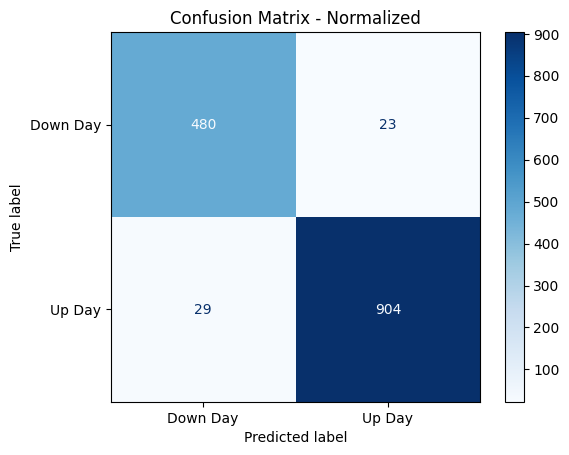

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


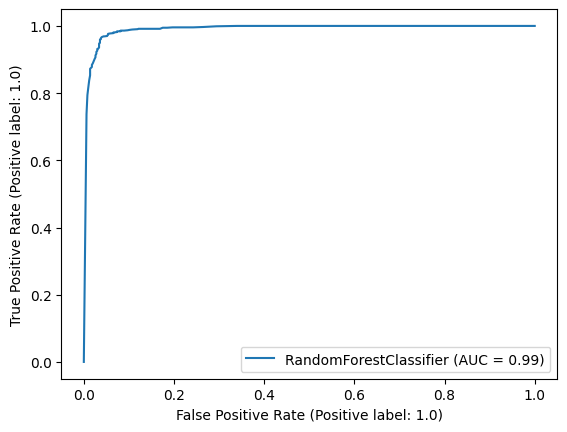

In [83]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para AMBEV.

In [84]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Ambev, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [ ]:
# Carregar o modelo salvo
rand_frst_clf_Ambev = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Utilizando a verificação da predicação com o preço real e não suavizado.

In [85]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_ABEV['Prediction'] = np.NaN  # Inicializando a coluna
price_data_ABEV['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_ABEV['Match'] = (price_data_ABEV['Prediction'] == price_data_ABEV['Verify']).astype(int)
overall_accuracy = price_data_ABEV['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_ABEV[price_data_ABEV['Date'] >= price_data_ABEV['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 52.67%

Precisão do modelo nos últimos 30 dias: 65.00%


#### Plotagem:

In [88]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

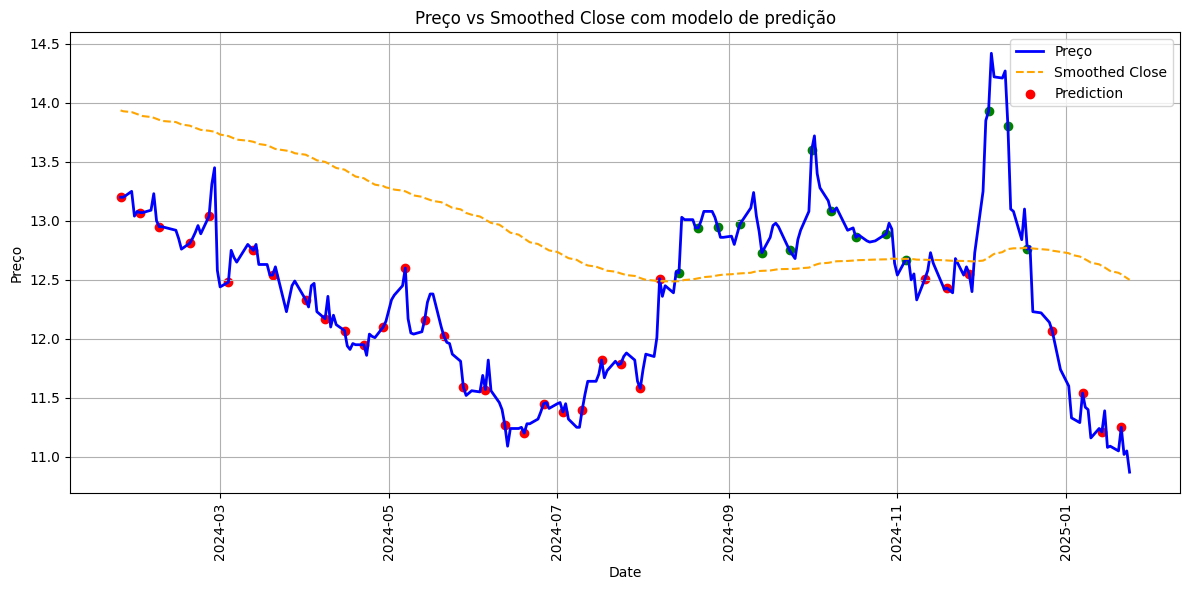

In [89]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 5):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### ITAÚ

#### Time series Cross-Validation

In [90]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_6,high_6,k_percent_6,r_percent_6,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17874,2001-01-08,3.112885,3.146001,3.079769,3.079769,1.766818,32069280,ITUB4.SA,-0.066066,2.964701,1.0,3.079769,1.0,3.093016,2.965984,0.066066,0.000000,59.059193,2.864351,3.22879,27.535346,-72.464654,0.000494,-0.004082,0.001401,310517539,1
17875,2001-01-09,3.112885,3.179117,3.079769,3.093016,1.774417,121066062,ITUB4.SA,0.013247,2.965984,1.0,3.093016,1.0,3.121164,2.967536,0.000000,0.013247,60.457838,2.905911,3.22879,18.605344,-81.394656,0.000686,-0.003128,0.002269,431583601,1
17876,2001-01-10,3.094671,3.129443,3.079604,3.121164,1.790566,110207199,ITUB4.SA,0.028148,2.967536,1.0,3.121164,1.0,3.129443,2.969155,0.000000,0.028148,63.463676,2.947306,3.22879,7.186770,-92.813230,0.000903,-0.002322,0.003227,541790800,1
17877,2001-01-11,3.144180,3.146001,3.063211,3.129443,1.795315,61589928,ITUB4.SA,0.008279,2.969155,1.0,3.129443,-1.0,3.080100,2.970264,0.000000,0.008279,64.366576,3.046653,3.22879,-42.549519,-142.549519,0.001143,-0.001629,0.003878,603380728,0
17878,2001-01-12,3.129443,3.129443,3.046653,3.080100,1.767006,49788916,ITUB4.SA,-0.049343,2.970264,1.0,3.080100,1.0,3.112885,2.971690,0.049343,0.000000,55.159028,3.046653,3.22879,-41.940387,-141.940387,0.001372,-0.001029,0.003895,653169644,1


In [91]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=80 , oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.94
  Accuracy with Verify: 0.50
Fold 2:
  Accuracy with Y_test (Prediction): 0.96
  Accuracy with Verify: 0.49
Fold 3:
  Accuracy with Y_test (Prediction): 0.94
  Accuracy with Verify: 0.48
Fold 4:
  Accuracy with Y_test (Prediction): 0.94
  Accuracy with Verify: 0.48
Fold 5:
  Accuracy with Y_test (Prediction): 0.92
  Accuracy with Verify: 0.48

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.94
  Média da acurácia com Verify: 0.48

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0    -1.0
3            1.0              1.0     1.0
4            1.0              1.0    -1.0
...          ...              ...     ...
4855        -1.0             -1.0     1.0
4856        -1.0             -1.0    -1.0
4857        -1.0             -1.0    -1.0
4858        -1.0             -1.0    -1.0
4859        -1.0    

#### Walk-Forward Validation

In [92]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

In [93]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Itau) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Itau.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.8944
  Accuracy with Verify: 0.4944
Window 2:
  Accuracy with Y_test (Prediction): 1.0000
  Accuracy with Verify: 0.5333
Window 3:
  Accuracy with Y_test (Prediction): 0.9722
  Accuracy with Verify: 0.5056
Window 4:
  Accuracy with Y_test (Prediction): 1.0000
  Accuracy with Verify: 0.4944
Window 5:
  Accuracy with Y_test (Prediction): 1.0000
  Accuracy with Verify: 0.5222
Window 6:
  Accuracy with Y_test (Prediction): 0.9000
  Accuracy with Verify: 0.4833
Window 7:
  Accuracy with Y_test (Prediction): 0.9167
  Accuracy with Verify: 0.5056
Window 8:
  Accuracy with Y_test (Prediction): 0.8167
  Accuracy with Verify: 0.4556
Window 9:
  Accuracy with Y_test (Prediction): 0.3444
  Accuracy with Verify: 0.4389
Window 10:
  Accuracy with Y_test (Prediction): 0.9778
  Accuracy with Verify: 0.5278
Window 11:
  Accuracy with Y_test (Prediction): 0.9556
  Accuracy with Verify: 0.4444
Window 12:
  Accuracy with Y_test (Prediction): 0.9167
  Accura

#### Split normal sem cross-validation.

In [94]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

In [95]:
# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators = 80, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Itau.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Itau.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Itau.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  94.45205479452055


In [96]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.900952,0.942231,0.921130,502.000000
Up Day,0.968984,0.945720,0.957211,958.000000
accuracy,0.944521,0.944521,0.944521,0.944521
macro avg,0.934968,0.943976,0.939170,1460.000000
weighted avg,0.945592,0.944521,0.944805,1460.000000


F1-Score: 0.9572
Accuracy: 0.9445205479452055
Precision: 0.9689839572192513
Recall: 0.9457202505219207
Specificity: 0.9422310756972112


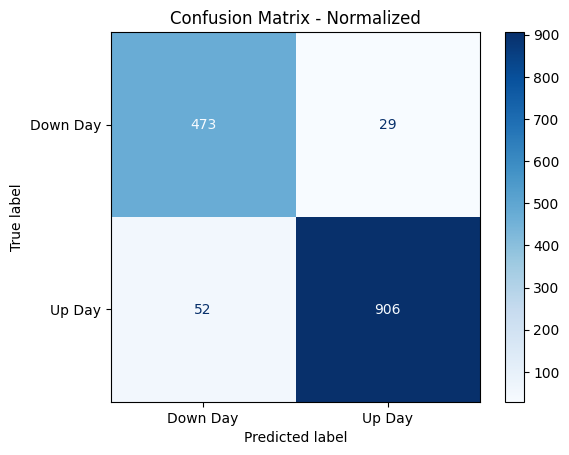

In [97]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)


# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


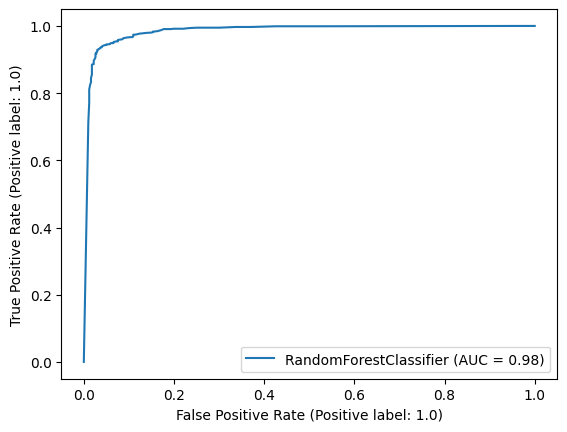

In [98]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Itau, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para ITAU.

In [469]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Itau, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [99]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Itau['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Itau['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Itau['Match'] = (price_data_Itau['Prediction'] == price_data_Itau['Verify']).astype(int)
overall_accuracy = price_data_Itau['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Itau[price_data_Itau['Date'] >= price_data_Itau['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Itau.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 51.88%

Precisão do modelo nos últimos 30 dias: 50.00%


#### Plotagem:

In [166]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

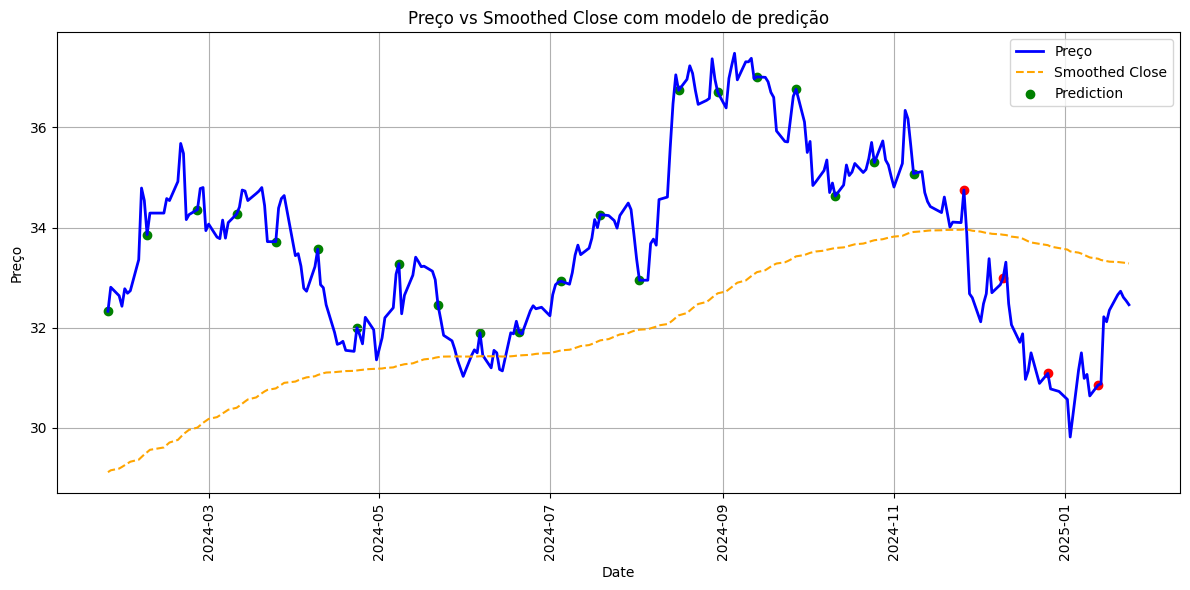

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ITUB4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### MAGALU

#### Time series Cross-Validation

In [101]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data_Magalu.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_6,high_6,k_percent_6,r_percent_6,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
23721,2011-05-17,4.705845,4.720459,4.682462,4.705845,4.334147,591538,MGLU3.SA,-0.073072,4.804580,-1.0,4.705845,-1.0,4.618158,4.802715,0.073072,0.000000,34.020991,4.676616,4.822760,87.559855,-12.440145,-0.000269,-0.012418,-0.000742,-10165857,1
23722,2011-05-18,4.691231,4.714614,4.609390,4.618158,4.253386,2380182,MGLU3.SA,-0.087687,4.802715,-1.0,4.618158,1.0,4.626927,4.800957,0.087687,0.000000,24.475779,4.609390,4.822760,90.605661,-9.394339,-0.000415,-0.010018,-0.001038,-12546039,0
23723,2011-05-19,4.618158,4.670770,4.606467,4.626927,4.261463,1514257,MGLU3.SA,0.008769,4.800957,-1.0,4.626927,1.0,4.659079,4.799539,0.000000,0.008769,26.803356,4.606467,4.822760,89.919885,-10.080115,-0.000614,-0.008137,-0.001423,-14060296,0
23724,2011-05-20,4.621081,4.673693,4.533395,4.659079,4.291075,1124573,MGLU3.SA,0.032152,4.799539,-1.0,4.659079,-1.0,4.641542,4.797959,0.000000,0.032152,35.113156,4.533395,4.799377,100.060809,0.060809,-0.000832,-0.006676,-0.001676,-15184869,1
23725,2011-05-23,4.606467,4.641542,4.545086,4.641542,4.274923,935719,MGLU3.SA,-0.017537,4.797959,-1.0,4.641542,-1.0,4.580161,4.795781,0.017537,0.000000,32.810556,4.533395,4.793532,101.701735,1.701735,-0.001077,-0.005556,-0.001891,-16120588,1


In [102]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.9494
  Accuracy with Verify: 0.5262
Fold 2:
  Accuracy with Y_test (Prediction): 0.9946
  Accuracy with Verify: 0.5588
Fold 3:
  Accuracy with Y_test (Prediction): 0.9855
  Accuracy with Verify: 0.5154
Fold 4:
  Accuracy with Y_test (Prediction): 0.9765
  Accuracy with Verify: 0.5389
Fold 5:
  Accuracy with Y_test (Prediction): 0.9946
  Accuracy with Verify: 0.5732

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.9801
  Média da acurácia com Verify: 0.5425

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0             -1.0     1.0
1           -1.0             -1.0     1.0
2           -1.0             -1.0    -1.0
3           -1.0             -1.0     1.0
4           -1.0             -1.0     1.0
...          ...              ...     ...
2760        -1.0             -1.0     1.0
2761        -1.0             -1.0     1.0
2762        -1.0             -1.0     1.0
2763        -1.0             -1.0     

#### Walk-Forward Validation

In [103]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [104]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Magalu) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Magalu.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.9556
  Accuracy with Verify: 0.5389
Window 2:
  Accuracy with Y_test (Prediction): 0.9333
  Accuracy with Verify: 0.4278
Window 3:
  Accuracy with Y_test (Prediction): 0.9056
  Accuracy with Verify: 0.4944
Window 4:
  Accuracy with Y_test (Prediction): 1.0000
  Accuracy with Verify: 0.6722
Window 5:
  Accuracy with Y_test (Prediction): 0.9722
  Accuracy with Verify: 0.5167
Window 6:
  Accuracy with Y_test (Prediction): 1.0000
  Accuracy with Verify: 0.6111
Window 7:
  Accuracy with Y_test (Prediction): 1.0000
  Accuracy with Verify: 0.5556
Window 8:
  Accuracy with Y_test (Prediction): 1.0000
  Accuracy with Verify: 0.5389
Window 9:
  Accuracy with Y_test (Prediction): 1.0000
  Accuracy with Verify: 0.5222
Window 10:
  Accuracy with Y_test (Prediction): 0.8944
  Accuracy with Verify: 0.5167
Window 11:
  Accuracy with Y_test (Prediction): 1.0000
  Accuracy with Verify: 0.4944
Window 12:
  Accuracy with Y_test (Prediction): 0.7611
  Accura

#### Split normal sem cross-validation.

In [105]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [106]:
# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators = 80, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Magalu.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Magalu.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Magalu.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  97.71359807460891


In [107]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.981328,0.979296,0.980311,483.000000
Up Day,0.971347,0.974138,0.972740,348.000000
accuracy,0.977136,0.977136,0.977136,0.977136
macro avg,0.976337,0.976717,0.976526,831.000000
weighted avg,0.977148,0.977136,0.977141,831.000000


F1-Score: 0.9727
Accuracy: 0.9771359807460891
Precision: 0.9713467048710601
Recall: 0.9741379310344828
Specificity: 0.979296066252588


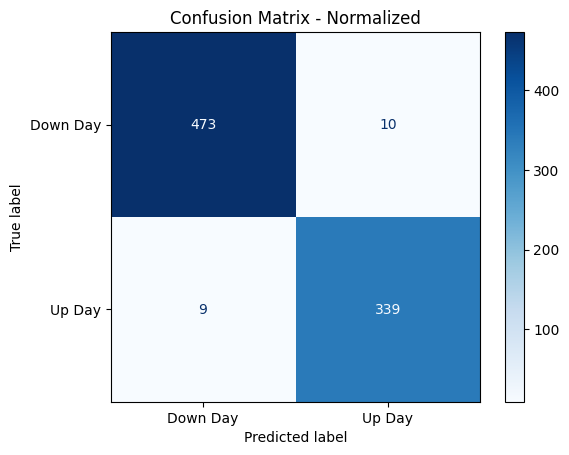

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)


# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


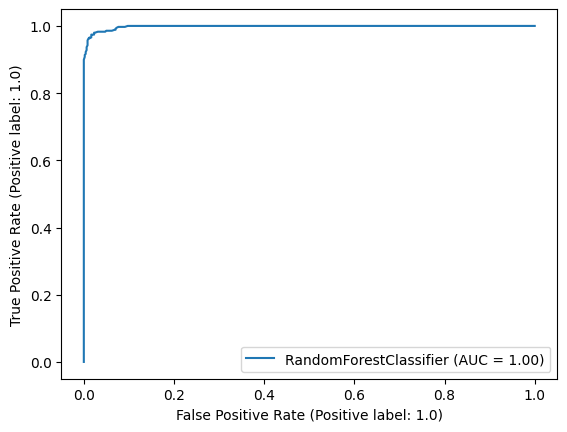

In [109]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para MAGALU.

In [481]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Magalu, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl']

#### Utilizando a verificação da predição com o preço real e não suavizado. Manter cross-validation.

In [110]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Magalu['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Magalu['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Magalu['Match'] = (price_data_Magalu['Prediction'] == price_data_Magalu['Verify']).astype(int)
overall_accuracy = price_data_Magalu['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Magalu[price_data_Magalu['Date'] >= price_data_Magalu['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 55.18%

Precisão do modelo nos últimos 30 dias: 50.00%


#### Plotagem:

In [111]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

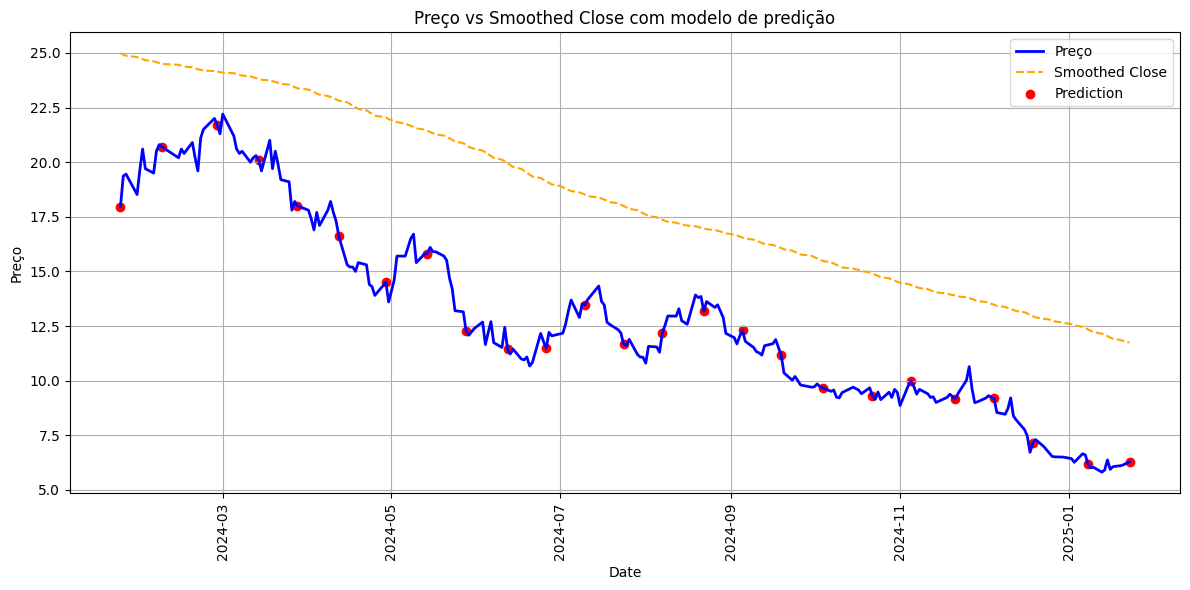

In [112]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'MGLU3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Petrobrás.

#### Time series Cross-Validation

In [113]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data_Petro.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_6,high_6,k_percent_6,r_percent_6,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17859,2025-01-20,37.220001,37.430000,37.110001,37.290001,37.290001,13912800,PETR4.SA,0.090000,37.261454,1.0,37.290001,1.0,37.299999,37.261839,0.000000,0.090000,54.912823,36.580002,37.529999,71.732009,-28.267991,0.004749,0.016376,-0.000602,-685093649915,1
17860,2025-01-21,37.099998,37.349998,36.720001,37.299999,37.299999,23612200,PETR4.SA,0.009998,37.261839,1.0,37.299999,-1.0,37.090000,37.260121,0.000000,0.009998,55.116666,36.580002,37.430000,80.216303,-19.783697,0.003394,0.013780,-0.000430,-685070037715,0
17861,2025-01-22,37.360001,37.630001,37.029999,37.090000,37.090000,21832200,PETR4.SA,-0.209999,37.260121,-1.0,37.090000,-1.0,36.830002,37.255820,0.209999,0.000000,49.761371,36.720001,37.630001,59.353809,-40.646191,0.002156,0.011455,-0.000358,-685091869915,1
17862,2025-01-23,37.119999,37.410000,36.700001,36.830002,36.830002,26725700,PETR4.SA,-0.259998,37.255820,-1.0,36.830002,-1.0,36.639999,37.249661,0.259998,0.000000,43.791062,36.700001,37.630001,59.765447,-40.234553,0.000819,0.009328,-0.000384,-685118595615,1
17863,2025-01-24,36.880001,36.900002,36.400002,36.639999,36.639999,16216500,PETR4.SA,-0.190002,37.249661,-1.0,36.639999,1.0,36.810001,37.245265,0.190002,0.000000,39.832908,36.400002,37.630001,69.078064,-30.921936,-0.000729,0.007316,-0.000496,-685134812115,0


In [114]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.9664
  Accuracy with Verify: 0.5381
Fold 2:
  Accuracy with Y_test (Prediction): 0.9654
  Accuracy with Verify: 0.4965
Fold 3:
  Accuracy with Y_test (Prediction): 0.9426
  Accuracy with Verify: 0.5054
Fold 4:
  Accuracy with Y_test (Prediction): 0.9436
  Accuracy with Verify: 0.4985
Fold 5:
  Accuracy with Y_test (Prediction): 0.9367
  Accuracy with Verify: 0.4975

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.9509
  Média da acurácia com Verify: 0.5072

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0    -1.0
3            1.0              1.0     1.0
4            1.0              1.0    -1.0
...          ...              ...     ...
5050         1.0              1.0     1.0
5051         1.0              1.0    -1.0
5052         1.0             -1.0    -1.0
5053        -1.0             -1.0    -

#### Walk-Forward Validation

In [115]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [116]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Petro) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Petro.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.8722
  Accuracy with Verify: 0.4389
Window 2:
  Accuracy with Y_test (Prediction): 0.9500
  Accuracy with Verify: 0.4944
Window 3:
  Accuracy with Y_test (Prediction): 0.9333
  Accuracy with Verify: 0.5333
Window 4:
  Accuracy with Y_test (Prediction): 0.9222
  Accuracy with Verify: 0.5000
Window 5:
  Accuracy with Y_test (Prediction): 1.0000
  Accuracy with Verify: 0.5556
Window 6:
  Accuracy with Y_test (Prediction): 0.9556
  Accuracy with Verify: 0.5944
Window 7:
  Accuracy with Y_test (Prediction): 0.8889
  Accuracy with Verify: 0.4667
Window 8:
  Accuracy with Y_test (Prediction): 0.8944
  Accuracy with Verify: 0.5389
Window 9:
  Accuracy with Y_test (Prediction): 0.9611
  Accuracy with Verify: 0.5500
Window 10:
  Accuracy with Y_test (Prediction): 0.5167
  Accuracy with Verify: 0.5222
Window 11:
  Accuracy with Y_test (Prediction): 0.9278
  Accuracy with Verify: 0.4556
Window 12:
  Accuracy with Y_test (Prediction): 0.9444
  Accura

#### Split normal sem cross-validation.

In [117]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [118]:
# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators = 80, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Petro.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Petro.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Petro.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  95.91567852437419


In [119]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.946087,0.946087,0.946087,575.000000
Up Day,0.967126,0.967126,0.967126,943.000000
accuracy,0.959157,0.959157,0.959157,0.959157
macro avg,0.956607,0.956607,0.956607,1518.000000
weighted avg,0.959157,0.959157,0.959157,1518.000000


F1-Score: 0.9671
Accuracy: 0.9591567852437418
Precision: 0.9671261930010604
Recall: 0.9671261930010604
Specificity: 0.9460869565217391


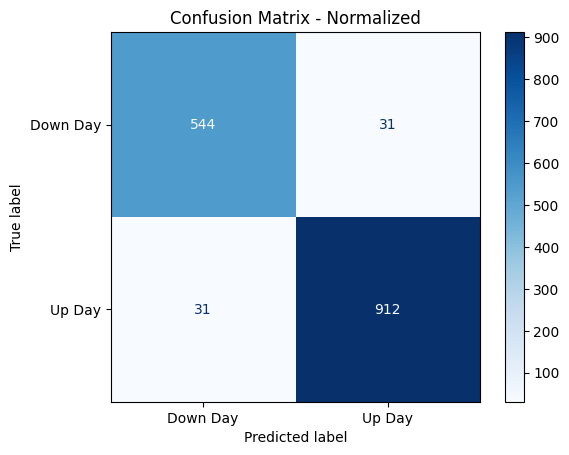

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


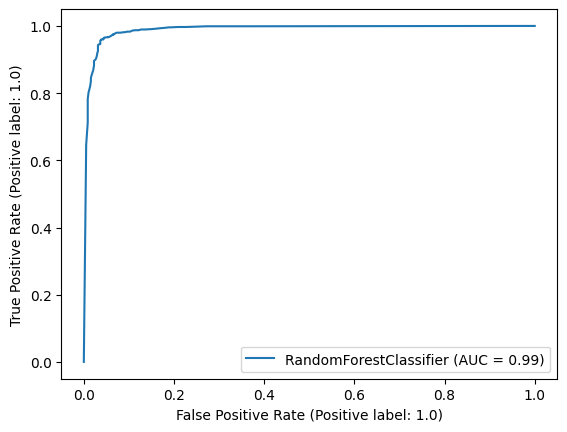

In [121]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [492]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Petro, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [122]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Petro['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Petro['Prediction'] = rand_frst_clf_Petro.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Petro['Match'] = (price_data_Petro['Prediction'] == price_data_Petro['Verify']).astype(int)
overall_accuracy = price_data_Petro['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Petro[price_data_Petro['Date'] >= price_data_Petro['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Petro.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 53.20%

Precisão do modelo nos últimos 30 dias: 55.00%


#### Plotagem:

In [123]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

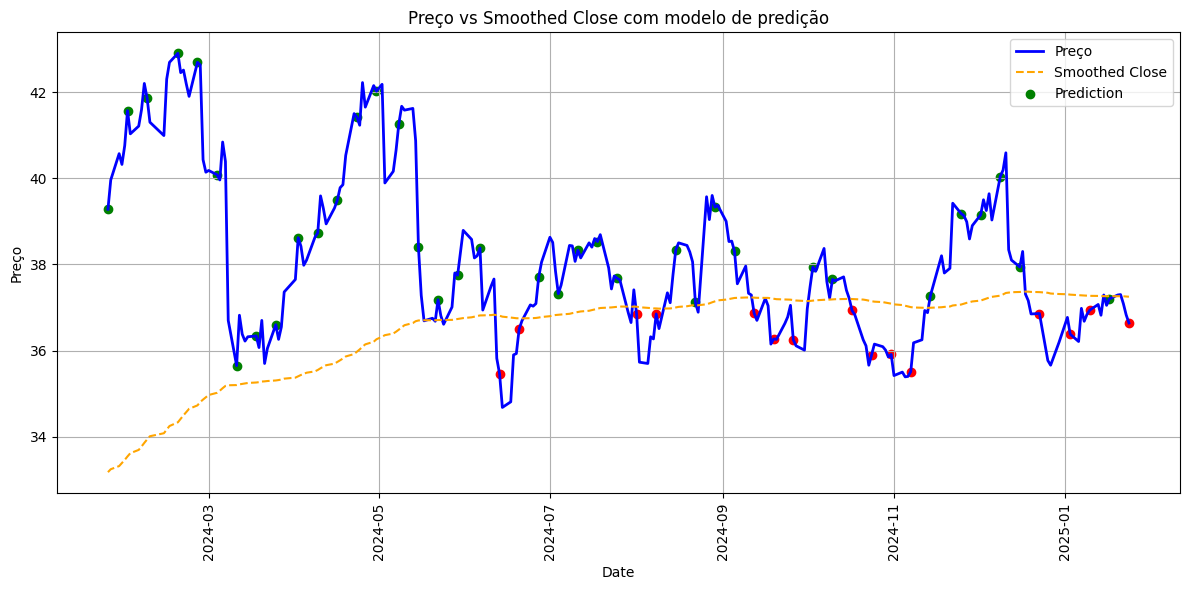

In [124]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'PETR4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 5):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Vale.

#### Time series Cross-Validation

In [125]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data_Vale.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_6,high_6,k_percent_6,r_percent_6,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5760,2000-01-17,4.083333,4.166666,4.083333,4.166666,1.814261,230400,VALE3.SA,0.083333,3.526401,1.0,4.166666,-1.0,4.041666,3.531554,0.000000,0.083333,94.184603,3.750000,4.166666,-53.663732,-153.663732,0.002335,0.001532,0.007543,14899200,0
5761,2000-01-18,4.125000,4.125000,4.025000,4.041666,1.759833,3724800,VALE3.SA,-0.125000,3.531554,1.0,4.041666,-1.0,4.025000,3.536489,0.125000,0.000000,74.214690,3.808333,4.166666,-77.240648,-177.240648,0.003091,0.001843,0.009256,18624000,0
5762,2000-01-19,4.041666,4.050833,4.000000,4.025000,1.752576,1872000,VALE3.SA,-0.016666,3.536489,1.0,4.025000,-1.0,4.000000,3.541124,0.016666,0.000000,71.910769,3.841666,4.166666,-93.900731,-193.900731,0.003874,0.002250,0.010904,20496000,0
5763,2000-01-20,4.000000,4.000000,4.000000,4.000000,1.741691,748800,VALE3.SA,-0.025000,3.541124,1.0,4.000000,-1.0,3.916666,3.544879,0.025000,0.000000,68.305773,4.000000,4.166666,-275.326844,-375.326844,0.004665,0.002733,0.012104,21244800,0
5764,2000-01-21,4.000000,4.000000,3.916666,3.916666,1.705405,144000,VALE3.SA,-0.083334,3.544879,1.0,3.916666,1.0,3.966666,3.549097,0.083334,0.000000,57.429421,3.916666,4.166666,-148.714772,-248.714772,0.005415,0.003269,0.012209,21388800,1


In [126]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.9482
  Accuracy with Verify: 0.5065
Fold 2:
  Accuracy with Y_test (Prediction): 0.9541
  Accuracy with Verify: 0.4905
Fold 3:
  Accuracy with Y_test (Prediction): 0.9272
  Accuracy with Verify: 0.5184
Fold 4:
  Accuracy with Y_test (Prediction): 0.9551
  Accuracy with Verify: 0.5085
Fold 5:
  Accuracy with Y_test (Prediction): 0.9671
  Accuracy with Verify: 0.5364

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.9503
  Média da acurácia com Verify: 0.5121

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0    -1.0
2            1.0              1.0    -1.0
3            1.0              1.0    -1.0
4            1.0              1.0     1.0
...          ...              ...     ...
5010        -1.0             -1.0    -1.0
5011        -1.0             -1.0    -1.0
5012        -1.0             -1.0    -1.0
5013        -1.0             -1.0     

#### Walk-Forward Validation

In [127]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [128]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Vale) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Vale.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.94
  Accuracy with Verify: 0.48
Window 2:
  Accuracy with Y_test (Prediction): 0.96
  Accuracy with Verify: 0.51
Window 3:
  Accuracy with Y_test (Prediction): 0.95
  Accuracy with Verify: 0.53
Window 4:
  Accuracy with Y_test (Prediction): 0.92
  Accuracy with Verify: 0.44
Window 5:
  Accuracy with Y_test (Prediction): 0.87
  Accuracy with Verify: 0.45
Window 6:
  Accuracy with Y_test (Prediction): 0.99
  Accuracy with Verify: 0.56
Window 7:
  Accuracy with Y_test (Prediction): 0.77
  Accuracy with Verify: 0.49
Window 8:
  Accuracy with Y_test (Prediction): 0.98
  Accuracy with Verify: 0.58
Window 9:
  Accuracy with Y_test (Prediction): 0.92
  Accuracy with Verify: 0.48
Window 10:
  Accuracy with Y_test (Prediction): 0.98
  Accuracy with Verify: 0.48
Window 11:
  Accuracy with Y_test (Prediction): 0.95
  Accuracy with Verify: 0.52
Window 12:
  Accuracy with Y_test (Prediction): 0.82
  Accuracy with Verify: 0.47
Window 13:
  Accuracy wit

#### Split normal sem cross-validation.

In [129]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [130]:
# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI',f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators = 80, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Vale.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Vale.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Vale.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  97.01195219123507


In [131]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.962205,0.966772,0.964483,632.00000
Up Day,0.975890,0.972540,0.974212,874.00000
accuracy,0.970120,0.970120,0.970120,0.97012
macro avg,0.969047,0.969656,0.969348,1506.00000
weighted avg,0.970147,0.970120,0.970129,1506.00000


F1-Score: 0.9742
Accuracy: 0.9701195219123506
Precision: 0.9758897818599311
Recall: 0.9725400457665904
Specificity: 0.9667721518987342


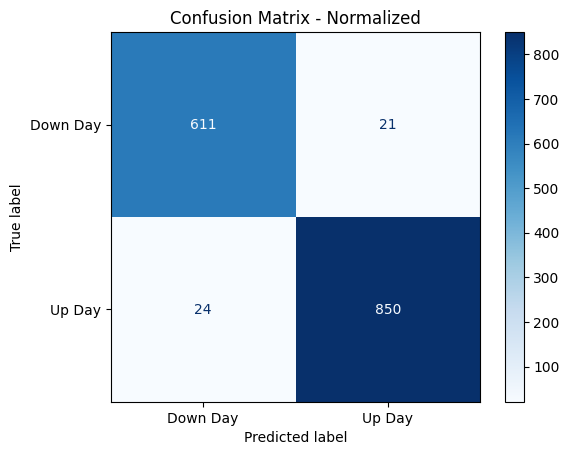

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
# Calculando o F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)


# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {:.4f}'.format(float(f1_score)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


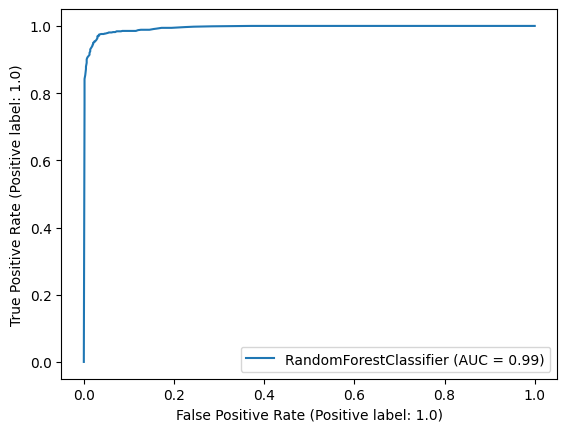

In [133]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [504]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Vale, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [134]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Vale['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Vale['Prediction'] = rand_frst_clf_Vale.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Vale['Match'] = (price_data_Vale['Prediction'] == price_data_Vale['Verify']).astype(int)
overall_accuracy = price_data_Vale['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Vale[price_data_Vale['Date'] >= price_data_Vale['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Vale.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 53.33%

Precisão do modelo nos últimos 30 dias: 70.00%


#### Plotagem:

In [135]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

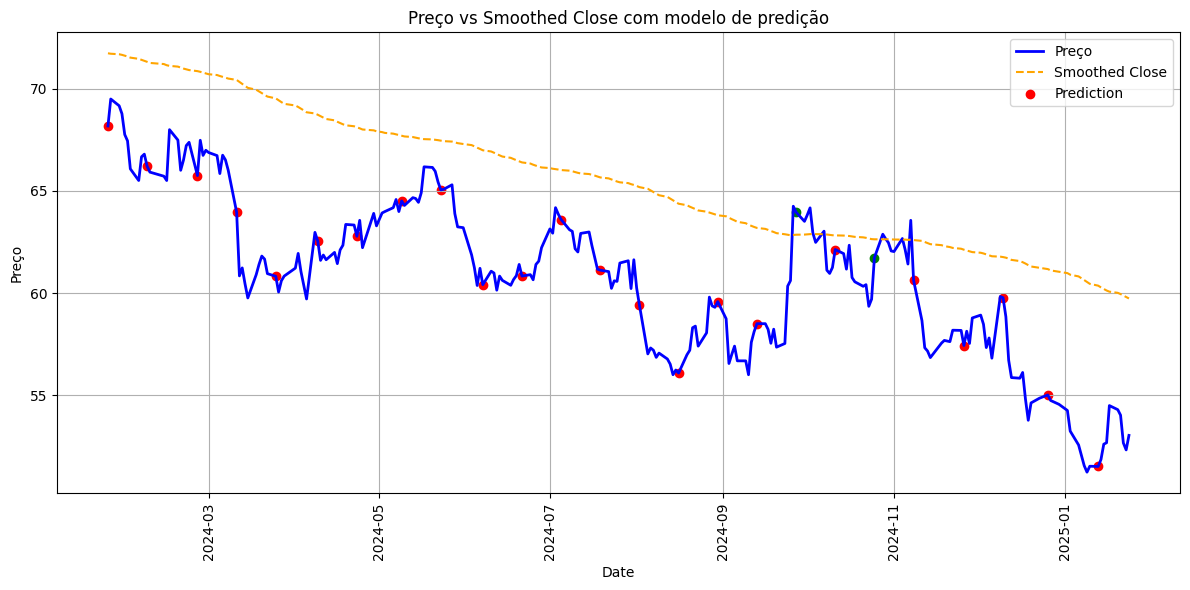

In [136]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend()
plt.grid()
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()
